In [1]:
# Install required packages.
!pip install torch

import os
import torch
import numpy as np
from tqdm import tqdm 

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.3.1+cu121


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


/opt/anaconda3/envs/CSE493G1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


total solution count: 5000
Dataset serialized and saved to '../../data/model-pickle/solutions_dataset_gnn_graphs.pkl'


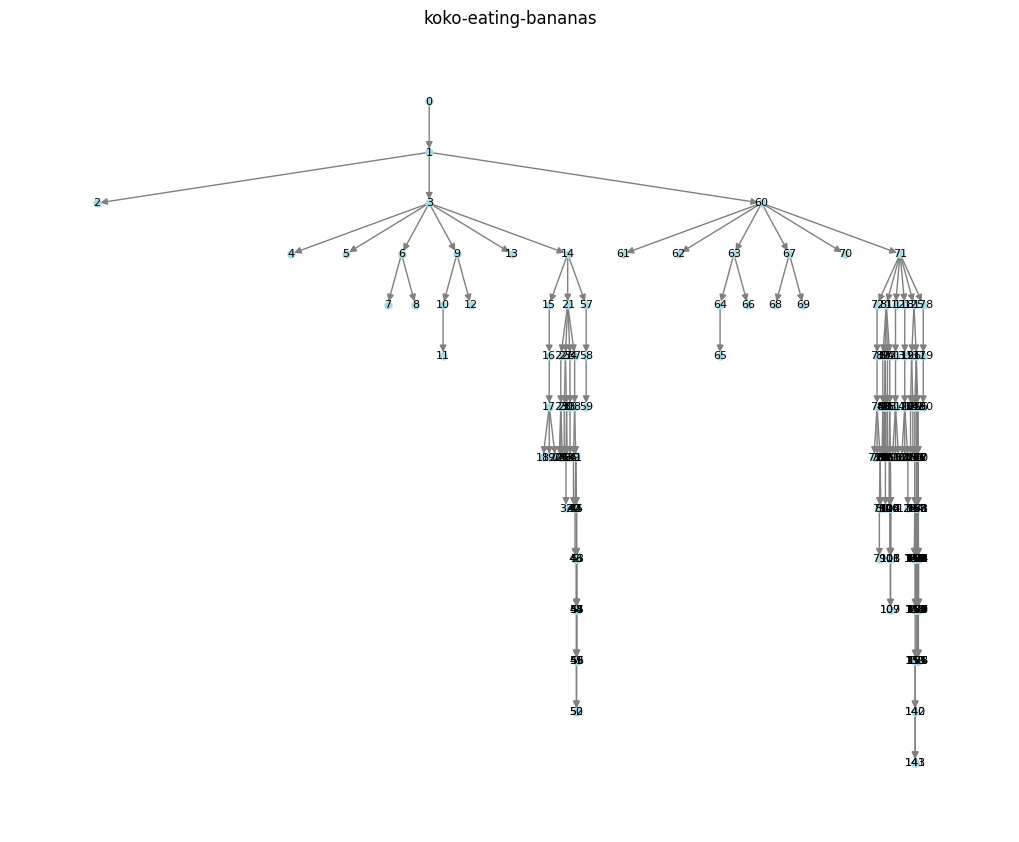

Solution: 0
Data(edge_index=[2, 180], name=[181], cooccurrences=[181, 139], num_nodes=181, x=[181, 139], y=[10])
Number of nodes: 181
Number of edges: 180
Average node degree: 0.99
Has isolated nodes: False
Has self-loops: False
Is undirected: False
x: tensor([[-0.1187, -0.1187, -0.1187,  ..., -0.1187, -0.1187, -0.1187],
        [-0.1707, -0.1707, -0.1707,  ..., -0.1707, -0.1707, -0.1707],
        [-0.1231, -0.1231, -0.1231,  ..., -0.1231, -0.1231, -0.1231],
        ...,
        [-0.1529, -0.1529,  0.0658,  ..., -0.1525, -0.1529, -0.1529],
        [-0.1515, -0.1515,  0.9832,  ...,  0.1190, -0.0980, -0.1515],
        [-0.1231, -0.1231, -0.1231,  ..., -0.1231, -0.1231, -0.1231]])
y: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])


/opt/anaconda3/envs/CSE493G1/lib/python3.10/site-packages/torch_geometric/utils/convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  data_dict[key] = torch.as_tensor(value)


In [3]:
# import torch
# import pickle
# from torch_geometric.datasets import TUDataset

# from google.colab import drive
# drive.mount('/content/drive')
# FOLDERNAME = 'cse493g1/project/data'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# %cd drive/My\ Drive

# dataset_path = os.path.join(FOLDERNAME, 'solutions_dataset_gnn_graphs.pkl')
# with open(dataset_path, 'rb') as f:
#     dataset = pickle.load(f)

from construct_gnn_dataset import SolutionDataset

dataset = SolutionDataset(root='../../data/raw')

In [4]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')



Dataset: SolutionDataset(5000):
Number of graphs: 5000
Number of features: 139


In [5]:
def printstats(index):
    data = dataset[index]  

    print()
    print(data)
    print('=============================================================')
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')
    print('=============================================================')
    print(f'Data.x: {data.x}')
    print(f'Data.y: {data.y}')

    return (data.x, data.y)

In [6]:
x1, y1 = printstats(0)
x2, y2 = printstats(-1)


Data(edge_index=[2, 165], name=[166], cooccurrences=[166, 139], num_nodes=166, x=[166, 139], y=[10])
Number of nodes: 166
Number of edges: 165
Average node degree: 0.99
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Data.x: tensor([[-0.1187, -0.1187, -0.1187,  ..., -0.1187, -0.1187, -0.1187],
        [-0.1707, -0.1707, -0.1707,  ..., -0.1707, -0.1707, -0.1707],
        [-0.1231, -0.1231, -0.1231,  ..., -0.1231, -0.1231, -0.1231],
        ...,
        [-0.1231, -0.1231, -0.1231,  ..., -0.1231, -0.1231, -0.1231],
        [-0.1515, -0.1515,  0.9832,  ...,  0.1190, -0.0980, -0.1515],
        [-0.1231, -0.1231, -0.1231,  ..., -0.1231, -0.1231, -0.1231]])
Data.y: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Data(edge_index=[2, 238], name=[239], cooccurrences=[239, 139], num_nodes=239, x=[239, 139], y=[10])
Number of nodes: 239
Number of edges: 238
Average node degree: 1.00
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Data.x: tensor([[-0.1187, -0.1187

In [7]:
NODE_FEATURES = dataset.num_features
NUM_CLASSES = dataset[0].y.size(-1)

print(NODE_FEATURES)
print(NUM_CLASSES)


139
10


In [8]:
assert (len(dataset) % 10 == 0)
split = (len(dataset) * 9) // 10

train_dataset = [item for i, item in enumerate(dataset) if (i + 1) % 10 != 0]
test_dataset = [item for i, item in enumerate(dataset) if (i + 1) % 10 == 0]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')


Number of training graphs: 4500
Number of test graphs: 500


In [9]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

for step, data in enumerate(train_loader):
    data = data.to(device)
    
    if (step) % 2500 == 0:
        print(f'Step {step}:')
        print('=======')
        print(f'Number of graphs in the current batch: {data.num_graphs}')
        print(data)
        print()

Step 0:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 91], name=[1], cooccurrences=[92, 139], num_nodes=92, x=[92, 139], y=[10], batch=[92], ptr=[2])

Step 2500:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 104], name=[1], cooccurrences=[105, 139], num_nodes=105, x=[105, 139], y=[10], batch=[105], ptr=[2])



## Training a Graph Neural Network (GNN)

Training a GNN for graph classification usually follows a simple recipe:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

There exists multiple **readout layers** in literature, but the most common one is to simply take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

The final architecture for applying GNNs to the task of graph classification then looks as follows and allows for complete end-to-end training:

In [10]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(NODE_FEATURES, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, NUM_CLASSES)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = self.conv5(x, edge_index)

        x = global_mean_pool(x, batch)  
        
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x


model = GCN(hidden_channels=250).to(device) 
print(model)

GCN(
  (conv1): GCNConv(139, 250)
  (conv2): GCNConv(250, 250)
  (conv3): GCNConv(250, 250)
  (conv4): GCNConv(250, 250)
  (conv5): GCNConv(250, 250)
  (lin): Linear(in_features=250, out_features=10, bias=True)
)


Here, we again make use of the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) with $\mathrm{ReLU}(x) = \max(x, 0)$ activation for obtaining localized node embeddings, before we apply our final classifier on top of a graph readout layer.

Let's train our network for a few epochs to see how well it performs on the training as well as test set:

In [11]:
EPOCHS = 30
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epoch_losses = {}
epoch_accuracies = {}

model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Progress"):
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        yTrue = batch.y.float().reshape(1, 10)
        loss = criterion(out, yTrue)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        max_idx = torch.argmax(out)
        predicted = torch.zeros_like(out)
        predicted[0][max_idx] = 1
        correct += 1 if (torch.equal(predicted, batch.y.float().reshape(1, 10))) else 0
        total += 1
    
    epoch_accuracy = correct / total
    epoch_losses[epoch + 1] = epoch_loss
    epoch_accuracies[epoch + 1] = epoch_accuracy
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Correct: {correct}, Total: {total}, Accuracy: {epoch_accuracy:.4f}")

print("Training completed.")


Epoch 1/30 Progress: 100%|██████████| 4500/4500 [00:19<00:00, 229.55it/s]


Epoch 1/30, Loss: 2893.7648, Correct: 3333, Total: 4500, Accuracy: 0.7407


Epoch 2/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 237.19it/s]


Epoch 2/30, Loss: 1361.5426, Correct: 3897, Total: 4500, Accuracy: 0.8660


Epoch 3/30 Progress: 100%|██████████| 4500/4500 [00:19<00:00, 229.92it/s]


Epoch 3/30, Loss: 1147.5786, Correct: 3949, Total: 4500, Accuracy: 0.8776


Epoch 4/30 Progress: 100%|██████████| 4500/4500 [00:19<00:00, 230.96it/s]


Epoch 4/30, Loss: 1150.3240, Correct: 3937, Total: 4500, Accuracy: 0.8749


Epoch 5/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 239.62it/s]


Epoch 5/30, Loss: 1047.2374, Correct: 3961, Total: 4500, Accuracy: 0.8802


Epoch 6/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 247.38it/s]


Epoch 6/30, Loss: 1100.2225, Correct: 3961, Total: 4500, Accuracy: 0.8802


Epoch 7/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 249.75it/s]


Epoch 7/30, Loss: 1015.6001, Correct: 3972, Total: 4500, Accuracy: 0.8827


Epoch 8/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 248.44it/s]


Epoch 8/30, Loss: 969.9649, Correct: 3983, Total: 4500, Accuracy: 0.8851


Epoch 9/30 Progress: 100%|██████████| 4500/4500 [00:19<00:00, 233.61it/s]


Epoch 9/30, Loss: 881.3106, Correct: 4004, Total: 4500, Accuracy: 0.8898


Epoch 10/30 Progress: 100%|██████████| 4500/4500 [00:19<00:00, 225.23it/s]


Epoch 10/30, Loss: 979.6630, Correct: 3989, Total: 4500, Accuracy: 0.8864


Epoch 11/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 247.96it/s]


Epoch 11/30, Loss: 869.1926, Correct: 4028, Total: 4500, Accuracy: 0.8951


Epoch 12/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 249.54it/s]


Epoch 12/30, Loss: 866.5035, Correct: 4012, Total: 4500, Accuracy: 0.8916


Epoch 13/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 248.48it/s]


Epoch 13/30, Loss: 816.2273, Correct: 4037, Total: 4500, Accuracy: 0.8971


Epoch 14/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 248.70it/s]


Epoch 14/30, Loss: 889.5263, Correct: 4009, Total: 4500, Accuracy: 0.8909


Epoch 15/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 248.57it/s]


Epoch 15/30, Loss: 913.0672, Correct: 4013, Total: 4500, Accuracy: 0.8918


Epoch 16/30 Progress: 100%|██████████| 4500/4500 [00:19<00:00, 228.29it/s]


Epoch 16/30, Loss: 966.9273, Correct: 4015, Total: 4500, Accuracy: 0.8922


Epoch 17/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 248.35it/s]


Epoch 17/30, Loss: 873.6652, Correct: 4023, Total: 4500, Accuracy: 0.8940


Epoch 18/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 243.56it/s]


Epoch 18/30, Loss: 967.6312, Correct: 4020, Total: 4500, Accuracy: 0.8933


Epoch 19/30 Progress: 100%|██████████| 4500/4500 [00:19<00:00, 231.26it/s]


Epoch 19/30, Loss: 821.4393, Correct: 4077, Total: 4500, Accuracy: 0.9060


Epoch 20/30 Progress: 100%|██████████| 4500/4500 [00:19<00:00, 228.00it/s]


Epoch 20/30, Loss: 887.1563, Correct: 4031, Total: 4500, Accuracy: 0.8958


Epoch 21/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 241.00it/s]


Epoch 21/30, Loss: 981.2798, Correct: 4031, Total: 4500, Accuracy: 0.8958


Epoch 22/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 244.85it/s]


Epoch 22/30, Loss: 902.3562, Correct: 4022, Total: 4500, Accuracy: 0.8938


Epoch 23/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 241.97it/s]


Epoch 23/30, Loss: 861.4851, Correct: 4069, Total: 4500, Accuracy: 0.9042


Epoch 24/30 Progress: 100%|██████████| 4500/4500 [00:19<00:00, 227.31it/s]


Epoch 24/30, Loss: 879.1496, Correct: 4002, Total: 4500, Accuracy: 0.8893


Epoch 25/30 Progress: 100%|██████████| 4500/4500 [00:19<00:00, 228.31it/s]


Epoch 25/30, Loss: 833.4410, Correct: 4044, Total: 4500, Accuracy: 0.8987


Epoch 26/30 Progress: 100%|██████████| 4500/4500 [00:19<00:00, 233.56it/s]


Epoch 26/30, Loss: 790.5196, Correct: 4057, Total: 4500, Accuracy: 0.9016


Epoch 27/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 243.52it/s]


Epoch 27/30, Loss: 971.8075, Correct: 4018, Total: 4500, Accuracy: 0.8929


Epoch 28/30 Progress: 100%|██████████| 4500/4500 [00:18<00:00, 243.77it/s]


Epoch 28/30, Loss: 823.6221, Correct: 4031, Total: 4500, Accuracy: 0.8958


Epoch 29/30 Progress: 100%|██████████| 4500/4500 [00:17<00:00, 261.56it/s]


Epoch 29/30, Loss: 983.6115, Correct: 4045, Total: 4500, Accuracy: 0.8989


Epoch 30/30 Progress: 100%|██████████| 4500/4500 [00:17<00:00, 263.38it/s]

Epoch 30/30, Loss: 845.7204, Correct: 4064, Total: 4500, Accuracy: 0.9031
Training completed.


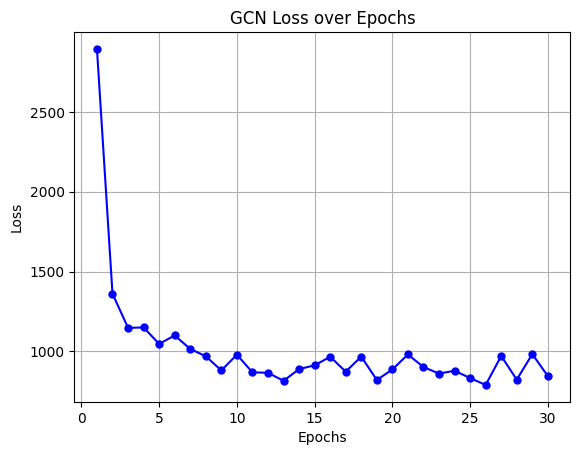

In [12]:
import matplotlib.pyplot as plt

epochs = list(epoch_losses.keys())
losses = list(epoch_losses.values())

plt.plot(epochs, losses, marker='o', color='b', linestyle='-', markersize=5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GCN Loss over Epochs')
plt.grid(True)
plt.show()

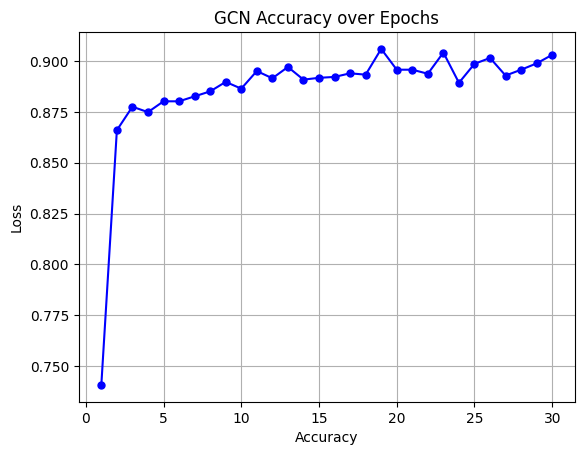

In [17]:
import matplotlib.pyplot as plt

epochs = list(epoch_accuracies.keys())
accs = list(epoch_accuracies.values())

plt.plot(epochs, accs, marker='o', color='b', linestyle='-', markersize=5)
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.title('GCN Accuracy over Epochs')
plt.grid(True)
plt.show()

In [13]:
MODEL_PATH = "GCNModel.pth"

In [14]:
torch.save(model, MODEL_PATH)

In [15]:
loaded_model = torch.load(MODEL_PATH)
loaded_model.eval()

GCN(
  (conv1): GCNConv(139, 250)
  (conv2): GCNConv(250, 250)
  (conv3): GCNConv(250, 250)
  (conv4): GCNConv(250, 250)
  (conv5): GCNConv(250, 250)
  (lin): Linear(in_features=250, out_features=10, bias=True)
)

In [16]:
def test(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing Progress"):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)  
            max_idx = torch.argmax(out)
            predicted = torch.zeros_like(out)
            predicted[0][max_idx] = 1
            correct += 1 if (torch.equal(predicted, batch.y.float().reshape(1, 10))) else 0
            total += 1
    
    accuracy = correct / total
    return accuracy

test_accuracy = test(loaded_model, test_loader)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Testing Progress: 100%|██████████| 500/500 [00:01<00:00, 382.36it/s]

Test Accuracy: 89.40%
